# 복습과제 1

## 데이터 작업하기

In [1]:
# Load torch

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다. (Use MNIST Data)
# Download FashionMNIST Dataset and transform to Tensor
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
# Download FashionMNIST Dataset and transform to Tensor
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 9852120.22it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 166268.50it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3102858.39it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1670323.90it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Dataset 을 DataLoader 의 인자로 전달합니다. 이는 데이터셋을 순회 가능한 객체(iterable)로 감싸고, 자동화된 배치(batch), 샘플링(sampling), 섞기(shuffle) 및 다중 프로세스로 데이터 불러오기(multiprocess data loading)를 지원합니다. 여기서는 배치 크기(batch size)를 64로 정의합니다. 즉, 데이터로더(dataloader) 객체의 각 요소는 64개의 특징(feature)과 정답(label)을 묶음(batch)으로 반환합니다.

In [3]:
batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## 모델 만들기

In [4]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), #784개의 input -> 512개의 hidden layer 1
            nn.ReLU(),
            nn.Linear(512, 512), # 512 -> 512 hidden layer 2
            nn.ReLU(),
            nn.Linear(512, 10) # 512 -> 10 output
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 모델 매개변수 최적화

In [6]:
loss_fn = nn.CrossEntropyLoss() # cross-entropy loss 이용
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # sgd algorithm으로 최적화

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y) # loss 계산하는 부분

        # 역전파
        optimizer.zero_grad() # gradient를 0으로 초기화
        loss.backward() # 역전파로 계산하는 단계
        optimizer.step() # 최적화

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311992  [   64/60000]
loss: 2.298050  [ 6464/60000]
loss: 2.275111  [12864/60000]
loss: 2.268600  [19264/60000]
loss: 2.239594  [25664/60000]
loss: 2.223774  [32064/60000]
loss: 2.228018  [38464/60000]
loss: 2.201890  [44864/60000]
loss: 2.206373  [51264/60000]
loss: 2.158059  [57664/60000]
Test Error: 
 Accuracy: 47.1%, Avg loss: 2.161129 

Epoch 2
-------------------------------
loss: 2.178791  [   64/60000]
loss: 2.165609  [ 6464/60000]
loss: 2.110060  [12864/60000]
loss: 2.127279  [19264/60000]
loss: 2.060447  [25664/60000]
loss: 2.022549  [32064/60000]
loss: 2.044194  [38464/60000]
loss: 1.974024  [44864/60000]
loss: 1.988568  [51264/60000]
loss: 1.899774  [57664/60000]
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.904019 

Epoch 3
-------------------------------
loss: 1.943441  [   64/60000]
loss: 1.910289  [ 6464/60000]
loss: 1.799061  [12864/60000]
loss: 1.838173  [19264/60000]
loss: 1.705598  [25664/60000]
loss: 1.677469  [32064/600

## 모델 저장하기

In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## 모델 불러오기

In [11]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## 예측하기

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# 복습과제 2

### Q1) What is the number of total parameters in this MLP model? Why?

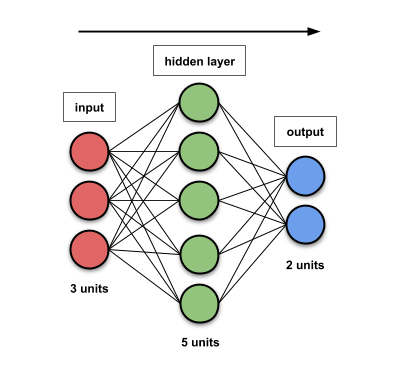

Your Answer:

input * weight = 3 * 5

bias = 5

hidden * weight = 5 * 2

bias = 2

total = 32

### Q2) Using the Gradient Descent Algorithm, the loss of the model will decrease continuously to a specific point, which is a minimum. Is it the optimal point? Why or why not?

Your Answer : The Gradient Descent Algorithm calculates the gradient of a function and continuously moving in the opposite direction to find a minimum value. So if the minimum value is a local minimum (not a global minimum), it is not the optimal point.

### Q3) Is it possible to decrease the training error to zero? *(Hint: Think about the Universal Approximation Theorem)*

Your Answer: According to the Universal Approximation Theorem, a neural network with a single hidden layer can perfectly approximate the given training data, reducing the training error to near zero.

### Q4) Is deep learning the best method to build models? That is, does deeper networks generalize better than other methods? *(Hint: it is somehow related with question 3)*

Your Answer: Deep learning is suitable for learning complex patterns, but with limited data size, there is a risk of overfitting. So it cannot always be considered as the best method to build models.